Here the modules are loaded as well as the MNIST dataset. This dataset is a a large dataset with 60.000 training samples and 10.000 test samples of handwritten digits. Notice that in the code below only the features (X) are used. Because we are creating new images, the labels are not necessary. Also note that the data here is normalized first. This is done by substracting 127.5 from the pixel values and then dividing the pixel values with 127.5. This makes sure the pixel values are normalized from -1 to 1.

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In this part, the generator network is created. This generator network consists out of multiple Dense, BatchNormalization, LeakyReLU and Conv2DTranspose layers. The generator network is used to generate the new samples. It works together with the discriminator network that will be discussed in the next part. 

In [18]:
# Define the generator network
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(4*4*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    model.build((None, 28, 28, 1)) 
    return model

In [19]:
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    model.build((None, 100)) 
    return model



Here, the discriminator network is created. This network gets the output data from the discriminator network and original data as input and has to say if it is a generated data or real data. This information is later used to update both the discriminator network and generator network. This makes sure the generator network starts to generate more and more realistic data.

In [20]:
# Define the discriminator network
def make_discriminator_model():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

Here, the loss functions of the generator network and the discriminator network are defined.

In [21]:
# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

# Define the generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define optimizers
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)


Here the generator model and discriminator model are defined. The optimzier are defined and the custom loss function are used. Also GradientType is used. GradientType is a class in TensorFlow that provides automatic differentiation for computing gradients of variables with respect to a loss function. 

In [22]:
# Define the generator and discriminator networks
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions and optimizers
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Define the training loop
@tf.function
def train_step(images):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

This code is used to generate and save multiple images from the generator network.

In [23]:
# Define a function to generate images from the generator network
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In this part the DCGAN is trained. For this, the same MNIST dataset is used. The train_dataset is created were the data is batched and shuffled. Then the DCGAN is trained for 50 epochs. Every 5th epoch, some generated samples are visualized so we can see the results of the network during training. 

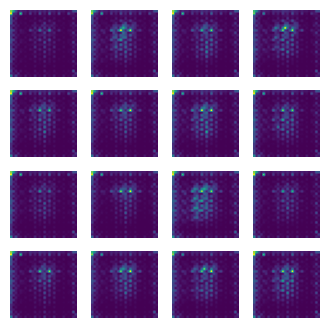

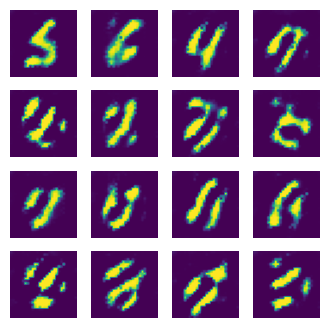

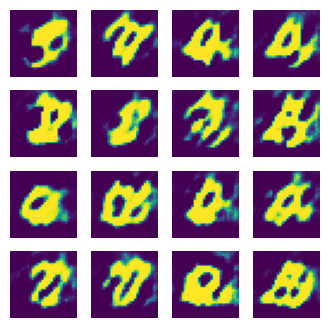

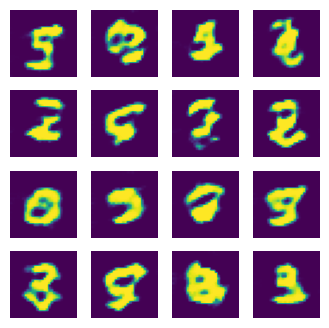

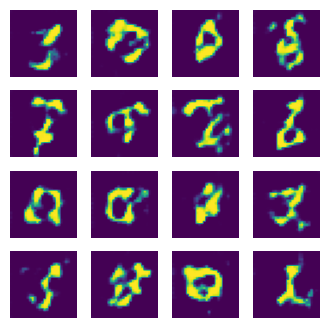

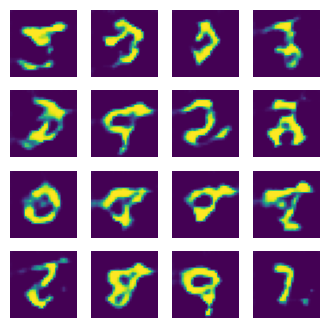

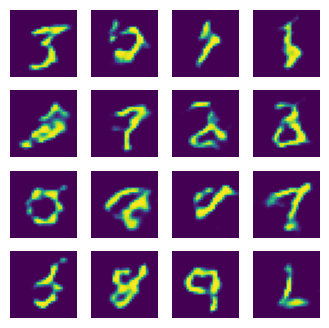

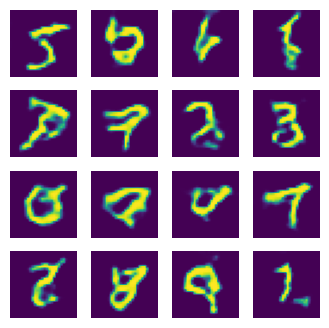

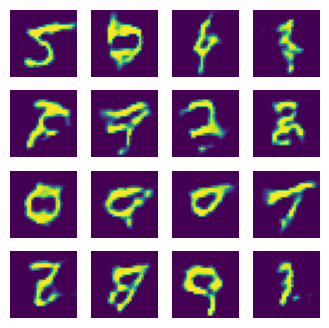

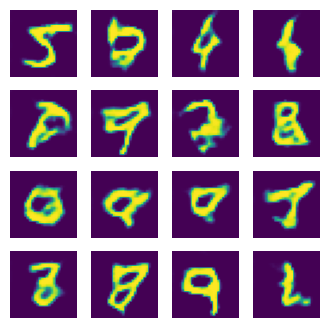

In [24]:
# Train the DCGAN
import numpy as np
import matplotlib.pyplot as plt

# # Load CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = keras.datasets.MNIST.load_data()

# # Normalize pixel values to [-1, 1]
# x_train = (x_train.astype('float32') - 127.5) / 127.5

# Reshape data 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(256)

# Generate random noise for visualization
test_noise = tf.random.normal([16, 100])

# Train the DCGAN for 50 epochs
epochs = 50
for epoch in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

    if epoch % 5 == 0:
        generate_and_save_images(generator, epoch, test_noise)


As can be seen in the previous results, the generator starts with nothing but quickly learns to generate images that have kind of the shape of a digit. The more the generator is trained, the more the images start to look like a digit. Ofcourse, this is not perfect yet. The generator can be improved or the model can be trained for more epochs to get a better result. 

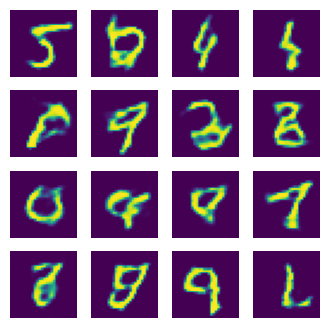

In [25]:
generate_and_save_images(generator, 50, test_noise)